In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
import seaborn as sns

from helpers.linkage import *
from helpers import dataloader
from helpers.visuals import add_cabinet_periods
from helpers.networks import *
import helpers.linkage as lkg
from helpers import network_visualization as nz

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import core data
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']
data = data['data']

# Set some lists/dictionaries for filtering
labels_reverse =dict(zip(labels.values(),labels.keys()))
indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

# Load members
mbs = pd.read_csv('helpers/members.csv',sep='\t')
name_id_dict = dict(zip(mbs.name,mbs.id))
id_name_dict = dict(zip(mbs.id,mbs.name))

# Quick function for easy lookup of speaker id's
def find_speaker(substring):
    return [(k,v) for k,v in id_name_dict.items() if substring in v.lower()]

/tmp/ipykernel_1818/4089098321.py:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


### Function for plotting speaker linkage network in period

In [9]:
def plot_speaker(ax,data,dists,labels,id='nl.m.01611',min_date=None,max_date=None,remove_nonsem=True,topic_prop_threshold=1,df_threshold=.95):
    
    """
    ax: plt. Axes
    data: DataFrame with metadata (and member-ref column)
    dists: topic-speech distribution in DataFrame format
    labels: dict of index-label pairs
    id: speaker id
    min_date: timestamp, pd.Timestamp(year=1945,month=1,day=1)
    max_date: timestamp, pd.Timestamp(year=1945,month=1,day=1)
    remove_nonsem: whether to remove rhet/proc/nonsem topics
    topic_prop_threshold: threshold for dropping topic irrelevant to a speaker, usually in range .1-5
    df_threshold: threshold for disparity filter, usually .9 or .95 works best
    """

    data_speaker = data[data['member-ref'] == id]
    if min_date != None and max_date != None:
        mask = (data.date > min_date) & (data.date <= max_date)
        data_speaker = data_speaker.loc[mask]
    speaker_theta = dists.reset_index().loc[data_speaker.index].set_index('date')

    # Get Normalized Topic Proportions for the speaker
    speaker_theta_prop = speaker_theta.mean(axis=0).reset_index()
    speaker_theta_prop.columns = ['topic_index','topic_prop_speaker']
    dists = dists.mean(axis=0).reset_index()
    dists.columns = ['topic_index','topic_prop']
    speaker_theta_prop = pd.merge(dists, speaker_theta_prop, on='topic_index', how='outer')
    speaker_theta_prop['norm_topic_prop_speaker'] = speaker_theta_prop['topic_prop_speaker'] / speaker_theta_prop['topic_prop']
    speaker_prop = dict(zip(speaker_theta_prop.topic_index,speaker_theta_prop.norm_topic_prop_speaker))

    speaker_topic_selection = [k for k,v in speaker_prop.items() if v > 1]

    theta = speaker_theta.to_numpy()
    theta,_,__ = mutual_information(theta)
    theta_flat = flatten_mi_array(theta)
    theta_flat.columns = ['source','target','weight']

    if remove_nonsem == True:
        theta_flat = theta_flat[~theta_flat.source.isin(indices_nonsem)]
        theta_flat = theta_flat[~theta_flat.target.isin(indices_nonsem)]
    if topic_prop_threshold != None:
        theta_flat = theta_flat[~theta_flat.source.isin(speaker_topic_selection)]
        theta_flat = theta_flat[~theta_flat.target.isin(speaker_topic_selection)]

    g,comm,edge_df = get_network_from_edge_dataframe(edge_df=theta_flat,dis_filter=df_threshold,thr=0,node_text='labels',labels=labels)
    layout = g.layout_kamada_kawai()

    visual_style = nz.default_style(g)
    visual_style['vertex_size'] = [speaker_prop[labels_reverse[i['name']]] * .75 for i in g.vs]
    visual_style['label_size'] = [speaker_prop[labels_reverse[i['name']]] * .75 for i in g.vs]
    visual_style['bbox'] = (1200,400)
    igraph.plot(comm,mark_groups = True,target=ax,layout=layout,**visual_style)

    nz.style_community_patches(ax)
    nz.style_nodes(ax,alpha=1)

    for i in ax.get_children():
        if isinstance(i,matplotlib.text.Text):
            if i.get_text() in labels_reverse.keys():
                if labels_reverse[i.get_text()] in speaker_prop.keys():
                    i.set_fontsize(speaker_prop[labels_reverse[i.get_text()]] * 15)
                
    ax.set_title(id_name_dict[id])

In [5]:
find_speaker('zijlstra')

[('nl.m.03068', 'Drs. H. (Halbe) Zijlstra'),
 ('nl.m.02990', 'Mr. M. (Martin) Zijlstra'),
 ('nl.m.01610', 'A. Zijlstra'),
 ('nl.m.01611', 'Dr. J. (Jelle) Zijlstra'),
 ('nl.m.02639', 'Dr. K. (Kees) Zijlstra'),
 ('nl.m.01612', 'Drs. R. (Rinse) Zijlstra')]

/home/rb/Documents/GitHub/linkage/helpers/networks.py:174: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:175: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("variance_max", 1)


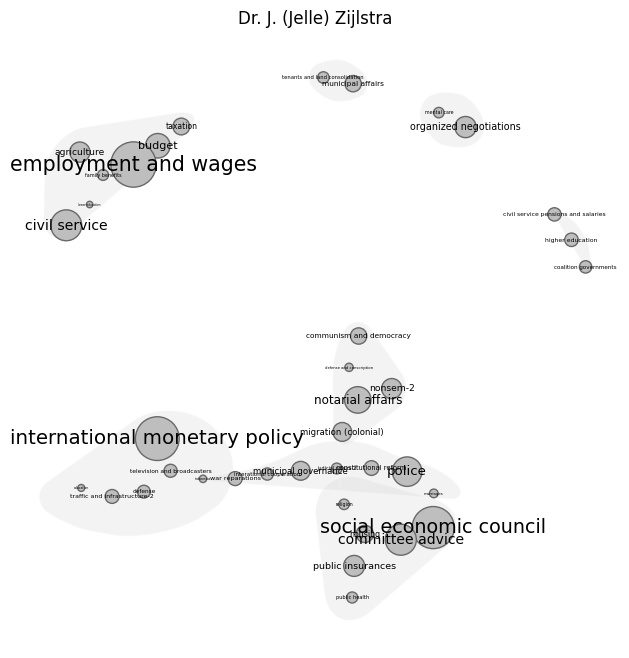

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

start,end = pd.Timestamp(year=1952,month=9,day=2),pd.Timestamp(year=1956,month=10,day=13)

plot_speaker(ax=ax,
            data=data,
            dists=dists,
            labels=labels,
            id='nl.m.01611',
            min_date=start,
            max_date=end,
            remove_nonsem=True,
            topic_prop_threshold=0,
            df_threshold=.85)